# **NEURAL NETWORKS FROM SCRATCH**

.

.

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, r2_score
from sklearn.metrics import precision_score,recall_score,f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve

import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

import warnings
warnings.filterwarnings("ignore")

2022-04-26 19:14:43.906757: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-26 19:14:43.906790: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


.

## **Define useful functions**

Initializing the weights to zero is not recommended. Andrew Ng (in his the online course about Machine Learning on Coursera) suggests the following initialization:

In [2]:
#Random initialization of weights
def randw(Lin,Lout) :
    # - Lin         dimension input layer
    # - Lout        dimension output layer
    
    np.random.seed(0)
    epsilon = (6 / (Lin+Lout))**0.5;
    return np.random.rand(Lout,Lin+1)*2*epsilon - epsilon

.

Different activation functions can be used in a Neural Network.

In [3]:
#Activation function
def act(function,X) :
    # - function    activation function "sigmoid","tanh","relu" 
    # - X           input matrix (data with no target column)
    
    if function == "sigmoid" :
        return 1./(1.+np.exp(-X))
    elif function == "tanh" :
        return np.tanh(X)
    elif function == "relu" :
        return np.where(X>=0,X,0)

.

We need a function to add a bias unit to layers during forward/backward propagation.

In [4]:
def Bias(m,A) :
    # - m           number of elements to add (on one row)
    # - X           input matrix (data with no target column)
    
    return np.vstack([np.ones((1,m)),A]) 

.

The *forward propagation* is useful to fo from the input layer to the output layer (Only one function will be applied to the whole net and the last function is the Sigmoid).

In [5]:
def Forward_propagation(task, function, X, theta1, theta2, theta3 = None) :        
    # - task        task of the function "classification" or "regression"
    # - function    activation function "sigmoid","tanh","relu" 
    # - X           input matrix (data with no target column)
    # - theta1      weights between input and first hidden layer
    # - theta2      weights between first hidden layers and second hidden layer (output layer if theta3=None)
    # - theta3      weights between second hidden layers and third (output) layer
    
    m = X.shape[0]                                 #Number of observations
    X = np.hstack([np.ones((m,1)),X])              #Add bias column
    a2 = act(function,np.dot(theta1,X.T))          #a1 = X.T
    
    if theta3 is None :                            #One hidden layer
        if task == "classification" :
            a3 = act("sigmoid",np.dot(theta2,Bias(m,a2)))      
        else :
            a3 = np.dot(theta2,Bias(m,a2))
        return a3.T   
    else :                                         #Two hidden layers
        a3 = act(function,np.dot(theta2,Bias(m,a2)))   
        if task == "classification" :
            a4 = act("sigmoid",np.dot(theta3,Bias(m,a3)))
        else :
            a4 = np.dot(theta3,Bias(m,a3))
        return a4.T

.

The Neural Network training requires the full *forward and back propagation* algorithm to optimize the weights by computing the gradient of the cost function.

(Only one function will be applied to the whole net).

In [6]:
def ForwardBack_propagation(task, function, X, y, theta1, theta2, theta3 = None) :
    # - task        task of the function "classification" or "regression"
    # - function    activation function "sigmoid","tanh","relu" 
    # - X           input matrix (data with no target column)
    # - yy          target variable transformed with OneHotEncoder (number of columns = number of classes)
    # - theta1      weights between input and first hidden layer
    # - theta2      weights between first hidden layers and second hidden layer (output layer if theta3=None)
    # - theta3      weights between second hidden layers and third (output) layer
    
    m = X.shape[0]                                 #Number of observations
    X = np.hstack([np.ones((m,1)),X])              #Add bias column
    a2 = act(function,np.dot(theta1,X.T))          #a1 = X.T
    
    if theta3 is None :                            #One hidden layer
        a4, d4 = 0,0
        if task == "classification" :
            a3 = act("sigmoid",np.dot(theta2,Bias(m,a2)))  
            d3 = a3-y.T
        else :
            a3 = np.dot(theta2,Bias(m,a2))
            d3 = a3-np.array(y).reshape(1,len(y))
        
        if function == "sigmoid" :
            d2 = (Bias(m,a2) * (1 - Bias(m,a2)) * np.dot(theta2.T,d3))[1:,:]
        elif function == "tanh" :
            d2 = ((1 - Bias(m,a2)**2) * np.dot(theta2.T,d3))[1:,:]
        else :
            d2 = (Bias(m,np.where(a2>=0,1,0)) * np.dot(theta2.T,d3))[1:,:]
        
    else :                                         #Two hidden layers
        if task == "classification" :
            a3 = act(function,np.dot(theta2,Bias(m,a2)))   
            a4 = act("sigmoid",np.dot(theta3,Bias(m,a3)))
            d4 = a4 - y.T
        else :
            a3 = act(function, np.dot(theta2,Bias(m,a2)))
            a4 = np.dot(theta3,Bias(m,a3))
            d4 = a4 - np.array(y).reshape(1,len(y))
            
        if function == "sigmoid" :        
            d3 = (np.dot(theta3.T,d4) * Bias(m,a3) * (1 - Bias(m,a3)))[1:,:]
            d2 = (np.dot(theta2.T,d3) * Bias(m,a2) * (1 - Bias(m,a2)))[1:,:]
        elif function == "tanh" :               
            d3 = (np.dot(theta3.T,d4) * (1 - Bias(m,a3)**2))[1:,:]
            d2 = (np.dot(theta2.T,d3) * (1 - Bias(m,a2)**2))[1:,:]
        else :
            d3 = (np.dot(theta3.T,d4) * Bias(m,np.where(a3>=0,1,0)))[1:,:]
            d2 = (np.dot(theta2.T,d3) * Bias(m,np.where(a2>=0,1,0)))[1:,:]
            
    return a2, a3, a4, d2, d3, d4

.

Finally, it is possible to create the Cost function and its gradient: in this function, the L2 regularization is added in the code.

In [7]:
def J_Grad(task, function, X, y, labels, Lambda, theta1, theta2, theta3 = None) :
    # - task        task of the function "classification" or "regression"
    # - function    activation function "sigmoid","tanh","relu" 
    # - X           input matrix (data with no target column)
    # - y           target variable
    # - labels      number of differen classes
    # - Lambda      regularization factor
    # - theta1      weights between input and first hidden layer
    # - theta2      weights between first hidden layers and second hidden layer (output layer if theta3=None)
    # - theta3      weights between second hidden layers and third (output) layer
    
    m = X.shape[0]
    inputs = X.shape[1]
    
    #Create target array (OneHotEncoder - number of columns = number of classes)
    if task == "classification" :
        yy = np.zeros((len(y),labels))
        for i in np.arange(0,m) :
            for k in np.arange(0,labels) :
                if y[i] == k :
                    yy[i,k] = 1
    else :
        yy = y
    
    #Forward and Back propagation
    a2, a3, a4, d2, d3, d4 = ForwardBack_propagation(task, function, X, yy, theta1, theta2, theta3)
    
    #Compute cost function and gradient
    Delta1 = np.dot(d2,np.hstack([np.ones((m,1)),X]))
    Delta2 = np.dot(d3,Bias(m,a2).T)
    t1grad = (Delta1+(np.hstack([np.zeros((theta1.shape[0],1)), theta1[:,1:]]))*Lambda)/m
    t2grad = (Delta2+(np.hstack([np.zeros((theta2.shape[0],1)), theta2[:,1:]]))*Lambda)/m        
    if theta3 is None :                            #One hidden layer
        REG = (np.sum(theta1[:,1:]**2) + np.sum(theta2[:,1:]**2))*Lambda/(2*m)  
        Delta3 = 0
        t3grad = Delta3
        if task == "classification" :
            J = sum(sum(-np.log10(a3)*yy.T - np.log10(1-a3)*(1-yy).T))/m + REG
        else :
            J = (d3**2).sum()/(2*m) + REG       
    else :                                         #Two hidden layers 
        REG = (np.sum(theta1[:,1:]**2) + np.sum(theta2[:,1:]**2) + np.sum(theta3[:,1:]**2))*Lambda/(2*m)
        Delta3 = np.dot(d4,Bias(m,a3).T)
        t3grad = (Delta3+(np.hstack([ np.zeros((theta3.shape[0],1)), theta3[:,1:]]))*Lambda)/m
        if task == "classification" :
            J = sum(sum(-np.log10(a4)*yy.T - np.log10(1-a4)*(1-yy).T))/m + REG
        else :
            J = (d4**2).sum()/(2*m) + REG        
            
    return J, t1grad, t2grad, t3grad

.

Finally, it is possible to create the Cost function and its gradient: in this function, the L2 regularization is added in the code.

.

Once weights have been optimized, the following function returns the final probabilities (only for classification) and the predictions.

In [8]:
def Prediction(task, function, X, theta1, theta2, theta3) :
    # - task        task of the function "classification" or "regression"
    # - function    activation function "sigmoid","tanh","relu" 
    # - X           input matrix (data with no target column)
    # - theta1      weights between input and first hidden layer
    # - theta2      weights between first hidden layers and second hidden layer (output layer if theta3=None)
    # - theta3      weights between second hidden layers and third (output) layer
    
    m = X.shape[0]
    Final = Forward_propagation(task, function, X, theta1, theta2, theta3)
    if task == "classification" :
        Predictions = []
        for i in np.arange(0,len(Final)) :
            Predictions.append(np.argmax(Final[i,:]))
        Final = Final[:,1]
    else :
        Predictions = Final.copy()
    
    return Final, Predictions

.

All the pieces are ready to write the Neural Network training function that implements the forward and back propagation algorithm up to a *Max_iter* iteration.

The following code includes the *early stopping* part: for classification, once the cost function on the validation set reaches its minimum, the algorithm stops to avoid overfitting; for regression, early stopping can be applied when the modification of the cost function are below a certain tolerance level.

The function return the last iteration epoch, the matrices of weights, the training and validation cost function values at each epoch.

In [9]:
def Training(task, function, X, y, X_test, y_test, alpha, Lambda, Max_iter, hid_layer1, hid_layer2 = None, flag = True) :
    # - task        task of the function "classification" or "regression"
    # - function    activation function "sigmoid","tanh","relu" 
    # - X           input matrix (data with no target column)
    # - y           target variable
    # - X_test      matrix for cross-validation
    # - y_test      target variable for cross-validation
    # - alpha       learning rate
    # - Lambda      regularization factor
    # - Max_iter    maximum number of iterations
    # - hid_layer1  number of nodes in the first hidden layer
    # - hid_layer2  number of nodes in the second hidden layer (if present)
    # - flag        flag to switch on/off early stopping
    
    inputs = X.shape[1]                     #Number of features
    Cost_value = 1e09                       #Value to start early stopping for classification
    tolerance = 1e-07                       #Tolerance value for regression early stopping
    
    #Number of labels (in the output)
    if task == "classification" :
        labels = len(pd.Series(y).unique())     
    else :
        labels = 1
        
    #Random initialization of weights
    if hid_layer2 is None :
        theta1 = randw(inputs, hid_layer1)
        theta2 = randw(hid_layer1, labels)
        theta3 = None
    else :
        theta1 = randw(inputs, hid_layer1)
        theta2 = randw(hid_layer1, hid_layer2)
        theta3 = randw(hid_layer2, labels)

    #Iterative training (i: epoch)
    Cost, Cost_te = [], []
    for i in range(Max_iter) :
        #Cost function and gradient
        A_tr, B_tr, C_tr, D_tr = J_Grad(task, function, X, y, labels, Lambda, theta1, theta2, theta3)
        A_te, B_te, C_te, D_te = J_Grad(task, function, X_test, y_test, labels, Lambda, theta1, theta2, theta3)
        #Update cost function lists
        Cost.append(A_tr)
        Cost_te.append(A_te)
        #Early stopping
        broken = 0
        if task == "classification" :
            if (flag == True) and (i>150) :        #To avoid initial flactuations
                diff = 100
                if (Cost_te[149] < Cost[149]) and ((A_tr - A_te) < 0) :
                    broken = 1
                else :
                    if A_te < Cost_value :
                        Cost_value = A_te
                    else :
                        broken = 1
        else :
            if (flag == True) and (i>150) :        #To avoid initial flactuations
                if abs(A_te - Cost_value) > tolerance :
                    Cost_value = A_te
                else :
                    broken = 1
        if broken==1 :
            break
            
        #Update weights
        if hid_layer2 is None :
            theta1 = theta1 - alpha*B_tr
            theta2 = theta2 - alpha*C_tr
        else :
            theta1 = theta1 - alpha*B_tr
            theta2 = theta2 - alpha*C_tr
            theta3 = theta3 - alpha*D_tr

    return i, theta1, theta2, theta3, Cost, Cost_te

.

.

.

.

.

## **Datasets for classification and regression**

The dataset for classification has been retrieved from https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names : it is about the *Pima Indians Diabetes*.

The dataset for regression is taken from the repository https://github.com/SamuComqi92/Car_price_prediction ("Car price" - the training and test sets has been already corrected and scaled)

In [10]:
#Import the data
#CLASSIFICATION
Data_class = pd.read_csv("dati2")
Data_class

,A,B,C,D,E,F,G,H,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [11]:
#REGRESSION
Data_train_regr = pd.read_csv("Car_Dataset_train.csv")
Data_test_regr = pd.read_csv("Car_Dataset_test.csv")
Data_train_regr = Data_train_regr.iloc[:,1:]
Data_test_regr = Data_test_regr.iloc[:,1:]

#Shape of the datasets
print(Data_train_regr.shape, Data_test_regr.shape)

#Creation of X and y (for training and testing)
X_train_regr = Data_train_regr.drop("CarPrice",axis=1)
y_train_regr = Data_train_regr.CarPrice
X_test_regr = Data_test_regr.drop("CarPrice",axis=1)
y_test_regr = Data_test_regr.CarPrice

X_train_regr

(194, 18) (11, 18)


,CarName,fueltype,aspiration,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,fuelsystem,boreratio,horsepower,citympg,highwaympg
0,0.869565,1.0,0.0,1.0,0.0,0.230321,0.411940,0.308333,0.400000,0.277735,0.2,0.139623,0.142857,0.464286,0.091667,0.444444,0.473684
1,0.434783,1.0,0.0,1.0,0.0,0.533528,0.505970,0.483333,0.550000,0.458495,0.2,0.298113,0.714286,0.871429,0.300000,0.166667,0.289474
2,0.869565,1.0,0.0,0.5,0.0,0.460641,0.514925,0.516667,0.508333,0.359193,0.2,0.230189,0.714286,0.550000,0.183333,0.388889,0.421053
3,0.130435,1.0,0.0,1.0,0.0,1.000000,1.000000,0.950000,0.741667,0.935609,0.6,0.932075,0.714286,0.900000,0.566667,0.027778,0.000000
4,0.869565,1.0,0.0,0.5,0.0,0.265306,0.262687,0.275000,0.558333,0.204422,0.2,0.116981,0.142857,0.364286,0.058333,0.500000,0.578947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,0.565217,1.0,0.0,1.0,0.0,0.367347,0.558209,0.633333,0.158333,0.640419,0.4,0.452830,0.714286,0.635714,0.466667,0.166667,0.236842
190,0.086957,1.0,0.0,1.0,0.0,0.492711,0.714925,0.550000,0.658333,0.607836,0.4,0.388679,0.714286,0.550000,0.304167,0.194444,0.236842
191,0.565217,1.0,0.0,0.5,0.0,0.230321,0.361194,0.291667,0.558333,0.174554,0.2,0.135849,0.142857,0.435714,0.087500,0.500000,0.552632
192,0.869565,1.0,0.0,1.0,0.0,0.475219,0.632836,0.616667,0.350000,0.592708,0.4,0.415094,0.714286,0.521429,0.470833,0.166667,0.210526


.

The datasets for classification must be transformed and prepared before training.

The features are all numeric:
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

In [12]:
#Missing values
print("Number of missing values: {}".format(Data_class.isna().sum().sum()))

Number of missing values: 0


In [13]:
#Target variable
Data_class.Class.value_counts()

0    500
1    268
Name: Class, dtype: int64

.

It is an unbalanced dataset. In this first part, let's work with a perfectly balanced dataset.

In [14]:
#Create a balanced dataset (268 records for each class)
Data_class_bal = pd.concat([Data_class[Data_class.Class==0].sample(268, random_state=0),Data_class[Data_class.Class==1]])

#Creation of X and y
X_class = Data_class_bal.drop(["Class"],axis=1)
y_class = Data_class_bal.Class
X_class = np.array(X_class)
y_class = np.array(y_class)

#Creation of training and test sets
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class,y_class,test_size=0.3,random_state=0)

#Feature scaling
scaler = MinMaxScaler()
scaler.fit(X_train_class)
X_train_class = scaler.transform(X_train_class)
X_test_class = scaler.transform(X_test_class)

.

.

.

## **Training: classification (balanced dataset)**

Let's search for the best set of hyperparameters with a grid search. The output will be:
 - Number of units in the hidden layer(s)
 - Learning rate
 - Activation function
 - Mean accuracy on the training set (standard deviation)
 - Mean accuracy on the test set (standard deviation)
 - Mean precision
 - Mean recall
 - Mean F1-score

In [15]:
#Grid search
Resultss = pd.DataFrame({"Units1":[],"Units2":[],"Alpha":[],"Function":[],
                         "Accuracy_tr":[],"Std_tr":[],"Accuracy_val":[],"Std_val":[],"Precision":[],"Recall":[],"F1-score":[]})
hid_layer1 = [2,4]
hid_layer2 = [None,2]
learning_rate = [0.8,1.0]
functions = ["sigmoid","tanh","relu"]
mod = 1
for i in hid_layer1 :
    for j in hid_layer2 :
        for a in learning_rate :
            for f in functions :
                acc, acc_te, pre, rec, f1s = [], [], [], [], []
                print(f'\rModel {mod}/{((len(hid_layer1))*(len(hid_layer2))*(len(learning_rate))*(len(functions)))} ', end='')       #Counter (%)
                for k in range(5) :
                    #Split Training set into training and validation sets (5 random sampling)
                    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train_class,y_train_class,test_size=0.2,random_state=k)
                    #Training
                    lastiter, t1, t2, t3, costr, cosval = Training("classification", f, X_train_t, y_train_t, X_test_t, y_test_t, a, 0.0, 2000, i, j, flag = True)
                    #Predictions
                    prob_tr, pred_tr = Prediction("classification", f, X_train_t, t1, t2, t3)
                    prob_te, pred_te = Prediction("classification", f, X_test_t, t1, t2, t3)    
                    #Update metrics
                    acc.append(accuracy_score(y_train_t, pred_tr))
                    acc_te.append(accuracy_score(y_test_t, pred_te))
                    pre.append(precision_score(y_test_t, pred_te))
                    rec.append(recall_score(y_test_t, pred_te))
                    f1s.append(f1_score(y_test_t, pred_te))
                    
                Resultss.loc[len(Resultss)] = [i,j,a,f,np.mean(acc),np.std(acc),np.mean(acc_te),np.std(acc_te),np.mean(pre),np.mean(rec),np.mean(f1s)]
                mod = mod+1

#Print results (highlight maximum results)
Resultss.style.highlight_max(subset=["Accuracy_tr","Accuracy_val","Precision","Recall","F1-score"] )

Model 24/24 

,Units1,Units2,Alpha,Function,Accuracy_tr,Std_tr,Accuracy_val,Std_val,Precision,Recall,F1-score
0,2.000000,None,0.800000,sigmoid,0.774667,0.013266,0.760000,0.022311,0.748650,0.782106,0.763456
1,2.000000,None,0.800000,tanh,0.712000,0.013098,0.690667,0.022940,0.648733,0.848648,0.721580
2,2.000000,None,0.800000,relu,0.728667,0.010242,0.669333,0.035176,0.726765,0.557502,0.623418
3,2.000000,None,1.000000,sigmoid,0.771333,0.013433,0.765333,0.024730,0.753650,0.787369,0.768584
4,2.000000,None,1.000000,tanh,0.730000,0.009661,0.674667,0.041825,0.685094,0.742607,0.675532
5,2.000000,None,1.000000,relu,0.716000,0.012184,0.682667,0.053599,0.825740,0.476461,0.597593
6,2.000000,2,0.800000,sigmoid,0.663333,0.114465,0.637333,0.128277,0.523175,0.581680,0.546683
7,2.000000,2,0.800000,tanh,0.700000,0.039328,0.629333,0.042500,0.685624,0.611711,0.598530
8,2.000000,2,0.800000,relu,0.662667,0.068909,0.592000,0.089879,0.529935,0.391463,0.448944
9,2.000000,2,1.000000,sigmoid,0.667333,0.117613,0.637333,0.128831,0.523508,0.581680,0.546711


.

The best model (i.e. high validation accuracy, small standard deviation) is model:
- Number of units in the first hidden layer: 2
- No second hidden layer
- Learning rate: 1.0
- Activation function: Sigmoid

.

Performance on the Test set: let's plot the cost function for the training and test set to see when early stopping can be applied (set flag=False).

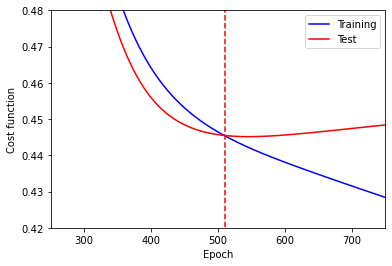

In [16]:
#Best hyperparameters
hid_layer1 = 2
hid_layer2 = None
alpha = 1.0
function = "sigmoid"

#Performance on the Test set
lastiter, t1, t2, t3, costr, cosval = Training("classification", function, 
                                               X_train_class, y_train_class, X_test_class, y_test_class, 
                                               alpha, 0.0, 2000, 
                                               hid_layer1, hid_layer2, 
                                               flag = False)

#Plot cost functions
plt.plot(costr,'blue')
plt.plot(cosval,'red')
plt.plot([510,510],[0.3,0.6],'--r')
plt.xlim([250,750])
plt.ylim([0.42,0.48])
plt.xlabel("Epoch")
plt.ylabel("Cost function")
plt.legend(["Training","Test"])

.

At epoch ~510, overfitting starts.

Now, let's use early stopping in the training function (set flag = True) to find the optimized weights.

Last iteration: 510 --- Train accuracy: 75.2% - Test accuracy: 73.29192546583852%

Precision:  0.76
Recall:  0.6951219512195121
F1-score:  0.7261146496815286


          Predicted 0  Predicted 1
Actual 0           61           18
Actual 1           25           57


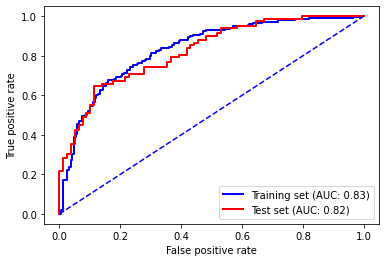

In [17]:
#Performance on the Test set
lastiter, t1, t2, t3, costr, cosval = Training("classification", function, 
                                               X_train_class, y_train_class, X_test_class, y_test_class, 
                                               alpha, 0.0, 2000, 
                                               hid_layer1, hid_layer2, 
                                               flag = True)

#Predictions
prob_tr, pred_tr = Prediction("classification", function, X_train_class, t1, t2, t3)
prob_te, pred_te = Prediction("classification", function, X_test_class, t1, t2, t3)    
print("Last iteration: {} --- Train accuracy: {}% - Test accuracy: {}%".format(lastiter,
                                                                               100*accuracy_score(y_train_class, pred_tr),
                                                                               100*accuracy_score(y_test_class, pred_te)))

#Confusion matrix
Conf_matrix = pd.DataFrame(confusion_matrix(y_test_class, pred_te))
Conf_matrix.index=["Actual 0", "Actual 1"]
Conf_matrix.columns=["Predicted 0", "Predicted 1"]
print("\nPrecision: ", precision_score(y_test_class, pred_te))
print("Recall: ", recall_score(y_test_class, pred_te))
print("F1-score: ", f1_score(y_test_class, pred_te))
print("\n")
print(Conf_matrix)


#ROC curves
fpr1, tpr1, thresholds1 = roc_curve(y_train_class,prob_tr)
fpr2, tpr2, thresholds2 = roc_curve(y_test_class,prob_te)
plt.plot(fpr1, tpr1,'blue',lw=2)
plt.plot(fpr2, tpr2,'red',lw=2)
plt.plot([0,1],[0,1],'--b')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Training set (AUC: {:.2f})".format(roc_auc_score(y_train_class,prob_tr)),
            "Test set (AUC: {:.2f})".format(roc_auc_score(y_test_class,prob_te))], loc="lower right")

.

For comparison, let's use the Logistic Regression model on the same dataset.


Logistic training accuracy:  0.7546666666666667
Logistic test accuracy:  0.7391304347826086

Precision:  0.7941176470588235
Recall:  0.6585365853658537
F1-score:  0.72


          Predicted 0  Predicted 1
Actual 0           65           14
Actual 1           28           54


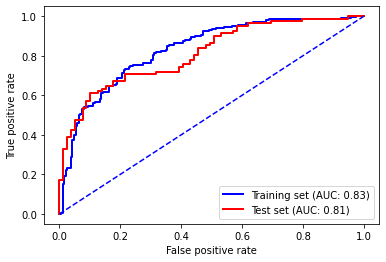

In [18]:
#For comparison: Logistic regression
Model_log = LogisticRegression(penalty="none").fit(X_train_class,y_train_class)
print("\nLogistic training accuracy: ", Model_log.score(X_train_class,y_train_class))
print("Logistic test accuracy: ", Model_log.score(X_test_class,y_test_class))

#Confusion matrix
y_pred_log = Model_log.predict(X_test_class)
Conf_matrix_log = pd.DataFrame(confusion_matrix(y_test_class, y_pred_log))
Conf_matrix_log.index=["Actual 0", "Actual 1"]
Conf_matrix_log.columns=["Predicted 0", "Predicted 1"]
print("\nPrecision: ", precision_score(y_test_class, y_pred_log))
print("Recall: ", recall_score(y_test_class, y_pred_log))
print("F1-score: ", f1_score(y_test_class, y_pred_log))
print("\n")
print(Conf_matrix_log)


#ROC curves
fpr1, tpr1, thresholds1 = roc_curve(y_train_class,Model_log.predict_proba(X_train_class)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test_class,Model_log.predict_proba(X_test_class)[:,1])
plt.plot(fpr1, tpr1,'blue',lw=2)
plt.plot(fpr2, tpr2,'red',lw=2)
plt.plot([0,1],[0,1],'--b')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Training set (AUC: {:.2f})".format(roc_auc_score(y_train_class,Model_log.predict_proba(X_train_class)[:,1])),
            "Test set (AUC: {:.2f})".format(roc_auc_score(y_test_class,Model_log.predict_proba(X_test_class)[:,1]))], loc="lower right")

.

Similar results in the end.

.

.

.

## **Training: classification (unbalanced dataset)**

Now, let's use the whole unbalanced dataset.

In [19]:
#Creation of X and y (from the unbalanced dataset)
X_class = Data_class.drop(["Class"],axis=1)
y_class = Data_class.Class
X_class = np.array(X_class)
y_class = np.array(y_class)

#Training and test set (70-30%)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class,y_class,test_size=0.3,random_state=0)

#Feature scaling
scaler = MinMaxScaler()
scaler.fit(X_train_class)
X_train_class = scaler.transform(X_train_class)
X_test_class = scaler.transform(X_test_class)

.

Let's search for the best set of hyperparameters with a grid search. The output will be:
 - Number of units in the hidden layer(s)
 - Learning rate
 - Activation function
 - Mean accuracy on the training set (standard deviation)
 - Mean accuracy on the test set (standard deviation)
 - Mean precision
 - Mean recall
 - Mean F1-score
 - Mean training AUC
 - Mean test AUC

In [20]:
#Grid search
Resultss3 = pd.DataFrame({"Units1":[],"Units2":[],"Alpha":[],"Function":[],
                         "Accuracy_tr":[],"Std_tr":[],"Accuracy_val":[],"Std_val":[],"Precision":[],"Recall":[],"F1-score":[],"AUC_tr":[],"AUC_val":[]})
hid_layer1 = [3,5]
hid_layer2 = [None,2]
learning_rate = [0.5,0.8]
functions = ["sigmoid","tanh","relu"]
mod = 1
for i in hid_layer1 :
    for j in hid_layer2 :
        for a in learning_rate :
            for f in functions :
                acc, acc_te, pre, rec, f1s, auc, auc_te = [], [], [], [], [], [], []
                print(f'\rModel {mod}/{((len(hid_layer1))*(len(hid_layer2))*(len(learning_rate))*(len(functions)))} ', end='')       #Counter (%)
                for k in range(5) :
                    #Split Training set into training and validation sets (5 random sampling)
                    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train_class,y_train_class,test_size=0.2,random_state=k)
                    #Training
                    lastiter, t1, t2, t3, costr, cosval = Training("classification", f, X_train_t, y_train_t, X_test_t, y_test_t, a, 0.0, 2000, i, j, flag = True)
                    #Predictions
                    prob_tr, pred_tr = Prediction("classification", f, X_train_t, t1, t2, t3)
                    prob_te, pred_te = Prediction("classification", f, X_test_t, t1, t2, t3)    
                    #Update metrics
                    acc.append(accuracy_score(y_train_t, pred_tr))
                    acc_te.append(accuracy_score(y_test_t, pred_te))
                    pre.append(precision_score(y_test_t, pred_te))
                    rec.append(recall_score(y_test_t, pred_te))
                    f1s.append(f1_score(y_test_t, pred_te))
                    auc.append(roc_auc_score(y_train_t,prob_tr))
                    auc_te.append(roc_auc_score(y_test_t,prob_te))
                    
                Resultss3.loc[len(Resultss3)] = [i,j,a,f,np.mean(acc),np.std(acc),np.mean(acc_te),np.std(acc_te),np.mean(pre),np.mean(rec),np.mean(f1s),np.mean(auc),np.mean(auc_te)]
                mod = mod+1

#Print results (highlight maximum results)
Resultss3.style.highlight_max(subset=["Accuracy_tr","Accuracy_val","Precision","Recall","F1-score","AUC_tr","AUC_val"] )

Model 24/24 

,Units1,Units2,Alpha,Function,Accuracy_tr,Std_tr,Accuracy_val,Std_val,Precision,Recall,F1-score,AUC_tr,AUC_val
0,3.000000,None,0.500000,sigmoid,0.757110,0.008647,0.777778,0.021114,0.740026,0.578192,0.646332,0.832995,0.835715
1,3.000000,None,0.500000,tanh,0.770629,0.002797,0.774074,0.019945,0.714999,0.609711,0.655311,0.843624,0.843560
2,3.000000,None,0.500000,relu,0.763170,0.002377,0.787037,0.020286,0.763924,0.584091,0.659949,0.832562,0.833354
3,3.000000,None,0.800000,sigmoid,0.758042,0.010042,0.774074,0.020787,0.731714,0.578192,0.642627,0.834037,0.836392
4,3.000000,None,0.800000,tanh,0.754312,0.015434,0.762963,0.034941,0.685639,0.679734,0.668750,0.839755,0.842263
5,3.000000,None,0.800000,relu,0.743124,0.015063,0.750000,0.037497,0.795656,0.436531,0.546566,0.821327,0.822139
6,3.000000,2,0.500000,sigmoid,0.761305,0.014860,0.766667,0.017954,0.714273,0.578342,0.634093,0.831480,0.833029
7,3.000000,2,0.500000,tanh,0.768765,0.012282,0.766667,0.034842,0.689326,0.638207,0.657906,0.827307,0.831232
8,3.000000,2,0.500000,relu,0.698834,0.011552,0.707407,0.044444,0.828485,0.220968,0.347875,0.825078,0.832011
9,3.000000,2,0.800000,sigmoid,0.759907,0.014743,0.766667,0.017954,0.714273,0.578342,0.634093,0.830944,0.833257


.

The best model (i.e. high validation AUC, high validation f1-score, high validation accuracy, precision and recall, small std on accuracies) is
- Number of units in the first hidden layer: 5
- Number of units in the second hidden layer: None
- Learning rate: 0.8
- Activation function: sigmoid

.

Now, it is possible to try to find the threshold that maximizes the f1-score.

Loop number 5/5 

Best threshold: 0.4
Largest f1-score: 0.7103813979207247


Text(0, 0.5, 'Metric')

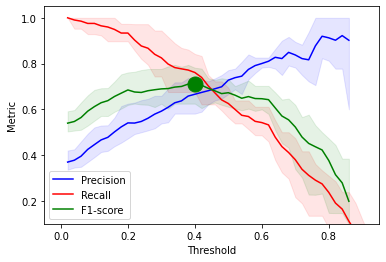

In [21]:
#Best hyperparameters
hid_layer1 = 5
hid_layer2 = None
alpha = 0.8
function = "sigmoid"

#Repeated random sampling (iterations: 5)
for k in range(5) :
    print(f'\rLoop number {k+1}/5 ', end='')       #Counter (%)
    #Split Training set into training and validation sets (5 random sampling)
    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train_class,y_train_class,test_size=0.2,random_state=k)
    #Training
    lastiter, t1, t2, t3, costr, cosval = Training("classification", function,
                                                   X_train_t, y_train_t, X_test_t, y_test_t, 
                                                   alpha, 0.0, 3000, 
                                                   hid_layer1, hid_layer2,
                                                   flag = True)
    #Predictions
    prob_te, pred_te = Prediction("classification", function, X_test_t, t1, t2, t3)    
    
    #Loop
    Thresh = np.arange(0.02,1.02,0.02)
    exec(f"Pre_{k}, Rec_{k} = [],[]")
    Rec = []
    for j in Thresh:
        A = prob_te.copy()
        A = np.where(A>=j,1,0)
        tn,fp,fn,tp = confusion_matrix(y_test_t,A).ravel()
        precision = tp/(tp + fp)
        recall = tp/(tp + fn)
        exec(f"Pre_{k}.append(precision); Rec_{k}.append(recall)")

#Mean Precision and Recall (for different thresholds)
Prec = np.array(Pre_0)
Reca = np.array(Rec_0)
for k in range(4):
    exec(f"AA = np.array(Pre_{k+1}); BB = np.array(Rec_{k+1})")
    Prec = np.vstack([Prec,AA])
    Reca = np.vstack([Reca,BB])
    
#Threshold that maximizes the F1-score
Index = np.nanargmax(2*(Reca.T.mean(axis=1)*Prec.T.mean(axis=1))/(Reca.T.mean(axis=1)+Prec.T.mean(axis=1)))
print("\n\nBest threshold: {}".format(Thresh[Index]))
print("Largest f1-score: {}".format((2*(Reca.T.mean(axis=1)*Prec.T.mean(axis=1))/(Reca.T.mean(axis=1)+Prec.T.mean(axis=1)))[Index]))

#Precision, Recall, and F1-score plot
plt.plot(Thresh, Prec.T.mean(axis=1),'-b')
plt.fill_between(Thresh,Prec.T.min(axis=1),Prec.T.max(axis=1),color='blue',alpha=0.1, label="_nolegend_")
plt.plot(Thresh, Reca.T.mean(axis=1),'-r')
plt.fill_between(Thresh,Reca.T.min(axis=1),Reca.T.max(axis=1),color='red',alpha=0.1, label="_nolegend_")
plt.plot(Thresh, 2*(Reca.T.mean(axis=1)*Prec.T.mean(axis=1))/(Reca.T.mean(axis=1)+Prec.T.mean(axis=1)),'-g')
plt.fill_between(Thresh, 2*(Reca.T.min(axis=1)*Prec.T.min(axis=1))/(Reca.T.min(axis=1)+Prec.T.min(axis=1)),
                 2*(Reca.T.max(axis=1)*Prec.T.max(axis=1))/(Reca.T.max(axis=1)+Prec.T.max(axis=1)), color="green",alpha=0.1)
plt.ylim([0.1,1.05])
plt.xlim([-0.05,0.95])
plt.plot(Thresh[Index], (2*(Reca.T.mean(axis=1)*Prec.T.mean(axis=1))/(Reca.T.mean(axis=1)+Prec.T.mean(axis=1)))[Index],'og',markersize=15)
plt.legend(["Precision","Recall","F1-score"])
plt.xlabel("Threshold")
plt.ylabel("Metric")

.

Let's use the model found above with the new threshold.

Accuracy:  0.7489177489177489

Precision:  0.5975609756097561
Recall:  0.6621621621621622
F1-score:  0.6282051282051282


          Predicted 0  Predicted 1
Actual 0          124           33
Actual 1           25           49


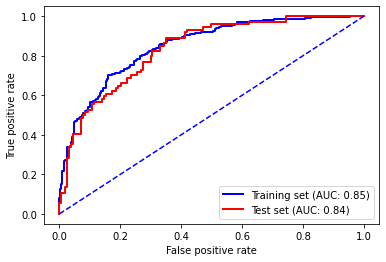

In [22]:
#Model + new threshold
lastiter, t1, t2, t3, costr, cosval = Training("classification", function,
                                                   X_train_class, y_train_class, X_test_class, y_test_class, 
                                                   alpha, 0.0, 3000, 
                                                   hid_layer1, hid_layer2,
                                                   flag = True)
#Predictions
prob_te, pred_te = Prediction("classification", function, X_test_class, t1, t2, t3)    

#New prediction (based on the new threshold)
Newpred = prob_te.copy()
Newpred = np.where(Newpred>=Thresh[Index],1,0)

    
#Confusion matrix
Conf_matrix = pd.DataFrame(confusion_matrix(y_test_class, Newpred))
Conf_matrix.index=["Actual 0", "Actual 1"]
Conf_matrix.columns=["Predicted 0", "Predicted 1"]
print("Accuracy: ", accuracy_score(y_test_class, Newpred))
print("\nPrecision: ", precision_score(y_test_class, Newpred))
print("Recall: ", recall_score(y_test_class, Newpred))
print("F1-score: ", f1_score(y_test_class, Newpred))
print("\n")
print(Conf_matrix)


#ROC curves
prob_tr, pred_tr = Prediction("classification", function, X_train_class, t1, t2, t3)    
fpr1, tpr1, thresholds1 = roc_curve(y_train_class,prob_tr)
fpr2, tpr2, thresholds2 = roc_curve(y_test_class,prob_te)
plt.plot(fpr1, tpr1,'blue',lw=2)
plt.plot(fpr2, tpr2,'red',lw=2)
plt.plot([0,1],[0,1],'--b')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Training set (AUC: {:.2f})".format(roc_auc_score(y_train_class,prob_tr)),
            "Test set (AUC: {:.2f})".format(roc_auc_score(y_test_class,prob_te))], loc="lower right")

In [23]:
#Confusion matrix (no threshold modification)
Conf_matrix = pd.DataFrame(confusion_matrix(y_test_class, pred_te))
Conf_matrix.index=["Actual 0", "Actual 1"]
Conf_matrix.columns=["Predicted 0", "Predicted 1"]
print("Accuracy: ", accuracy_score(y_test_class, pred_te))
print("\nPrecision: ", precision_score(y_test_class, pred_te))
print("Recall: ", recall_score(y_test_class, pred_te))
print("F1-score: ", f1_score(y_test_class, pred_te))
print("\n")
print(Conf_matrix)

Accuracy:  0.7835497835497836

Precision:  0.7068965517241379
Recall:  0.5540540540540541
F1-score:  0.6212121212121213


          Predicted 0  Predicted 1
Actual 0          140           17
Actual 1           33           41


.

Without the threshold modification, the accuracy on the test set is higher. However, the number of true positives is lower.

.

For comparison, let's use the Logistic regression model (no threshold modification).



Logistic training accuracy:  0.7653631284916201
Logistic test accuracy:  0.7792207792207793

Precision:  0.7090909090909091
Recall:  0.527027027027027
F1-score:  0.6046511627906976




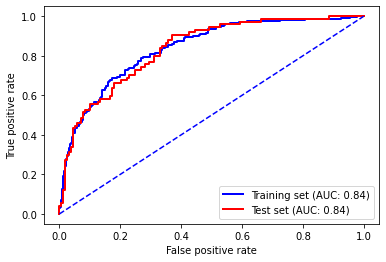

In [24]:
#Logistic regression
Model_log = LogisticRegression(penalty="none").fit(X_train_class,y_train_class)
print("\n\nLogistic training accuracy: ", Model_log.score(X_train_class,y_train_class))
print("Logistic test accuracy: ", Model_log.score(X_test_class,y_test_class))
y_pred_log = Model_log.predict(X_test_class)

#Confusion matrix
Conf_matrix_log = pd.DataFrame(confusion_matrix(y_test_class, y_pred_log))
Conf_matrix_log.index=["Actual 0", "Actual 1"]
Conf_matrix_log.columns=["Predicted 0", "Predicted 1"]
print("\nPrecision: ", precision_score(y_test_class, y_pred_log))
print("Recall: ", recall_score(y_test_class, y_pred_log))
print("F1-score: ", f1_score(y_test_class, y_pred_log))
print("\n")
Conf_matrix_log

#ROC curves
fpr1, tpr1, thresholds1 = roc_curve(y_train_class,Model_log.predict_proba(X_train_class)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test_class,Model_log.predict_proba(X_test_class)[:,1])
plt.plot(fpr1, tpr1,'blue',lw=2)
plt.plot(fpr2, tpr2,'red',lw=2)
plt.plot([0,1],[0,1],'--b')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Training set (AUC: {:.2f})".format(roc_auc_score(y_train_class,Model_log.predict_proba(X_train_class)[:,1])),
            "Test set (AUC: {:.2f})".format(roc_auc_score(y_test_class,Model_log.predict_proba(X_test_class)[:,1]))], loc="lower right")

.

.

.

.

.

.

# **Neural Network with KERAS**

Now, let's try to use Keras to build different Neural Networks.

Let's use the same parameters found before and test the model on the Test set.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 45        
                                                                 
 activation (Activation)     (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


2022-04-26 19:21:24.996738: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-26 19:21:24.996785: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-26 19:21:24.996809: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (samuele-300E5EV-300E4EV-270E5EV-270E4EV): /proc/driver/nvidia/version does not exist



Last iteration:  296
Training accuracy:  0.7579143643379211
Test accuracy:  0.7402597665786743

Test precision:  0.5945945978164673
Test recall:  0.5945945978164673
Test f1-score:  0.5945945978164673

           Predicted 0  Predicted 1
Actual 0          127           30
Actual 1           30           44


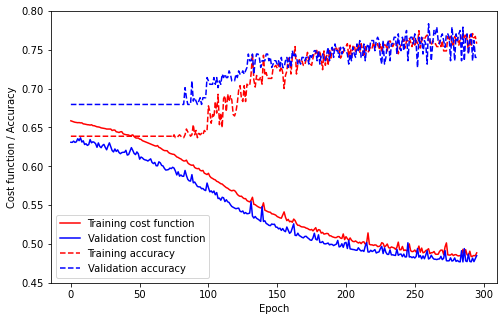

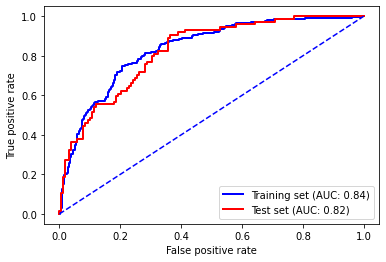

In [25]:
#Best hyperparameters
hid_layer1 = 5
hid_layer2 = None
alpha = 0.8
function = "sigmoid"


#Model
Model = Sequential()
Model.add(Dense(units=hid_layer1, input_shape=X_train_class.shape[1:]))
Model.add(Activation(function))
Model.add(Dense(units=1, activation="sigmoid"))             #One output (0 or 1)
Model.summary()


#Training
#Batch size equal to the number of sample (to reduce mini-batch SGD to batch gradient descent)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)          #Early stopping
Epochs = 1000
Model.compile(optimizer=keras.optimizers.SGD(lr = alpha),loss="binary_crossentropy",metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
Run = Model.fit(X_train_class, y_train_class, validation_data=(X_test_class,y_test_class), batch_size=len(X_train_t), epochs=Epochs, verbose=0, callbacks=[callback],shuffle=True)

#Results
print("\nLast iteration: ", len(Run.history["loss"]))
print("Training accuracy: ", Run.history["accuracy"][-1])
print("Test accuracy: ", Run.history["val_accuracy"][-1])
print("\nTest precision: ", Run.history[list(Run.history)[6]][-1])
print("Test recall: ", Run.history[list(Run.history)[7]][-1])
print("Test f1-score: ", 2*((Run.history[list(Run.history)[6]][-1])*(Run.history[list(Run.history)[7]][-1]))/((Run.history[list(Run.history)[6]][-1])+(Run.history[list(Run.history)[7]][-1])))

#Confusion matrix (the function "predict_classes" does not exist anymore)
Pred = Model.predict(X_test_class)
Newpred = Pred.copy()
Newpred = np.where(Newpred>=0.5,1,0)    
Conf_matrix = pd.DataFrame(confusion_matrix(y_test_class, Newpred))
Conf_matrix.index=["Actual 0", "Actual 1"]
Conf_matrix.columns=["Predicted 0", "Predicted 1"]
print("\n",Conf_matrix)


#Plot: accuracy curves
plt.figure(figsize=(8,5))
plt.plot(Run.history["loss"],'-r')
plt.plot(Run.history["val_loss"],"-b")
plt.plot(Run.history["accuracy"],'--r')
plt.plot(Run.history["val_accuracy"],"--b")
plt.ylim([0.45,0.80])
plt.xlabel("Epoch")
plt.ylabel("Cost function / Accuracy")
plt.legend(["Training cost function","Validation cost function","Training accuracy","Validation accuracy"])
plt.show()

#ROC curves
fpr1, tpr1, thresholds1 = roc_curve(y_train_class,Model.predict(X_train_class))
fpr2, tpr2, thresholds2 = roc_curve(y_test_class,Model.predict(X_test_class))
plt.plot(fpr1, tpr1,'blue',lw=2)
plt.plot(fpr2, tpr2,'red',lw=2)
plt.plot([0,1],[0,1],'--b')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Training set (AUC: {:.2f})".format(roc_auc_score(y_train_class,Model.predict(X_train_class))),
            "Test set (AUC: {:.2f})".format(roc_auc_score(y_test_class,Model.predict(X_test_class)))], loc="lower right")
plt.show()

.

.

.

.

.

## **Training: regression**

In [27]:
#Training with a parameter grid
Resultss6 = pd.DataFrame({"Units1":[],"Units2":[],"Alpha":[],"Function":[],"RMSE_tr":[],"Std_tr_1":[],"RMSE_val":[],"Std_val_1":[],
                          "MAE_tr":[],"Std_tr_2":[],"MAE_val":[],"Std_val_2":[],"R2_tr":[],"Std_tr_3":[],"R2_val":[],"Std_val_3":[]})

hidden1 = [2,5]
hidden2 = [None,2]
alpha = [0.5,1.0]
functions = ["sigmoid","tanh"]
mod=1
for i in hidden1 :
    for j in hidden2 :
        for a in alpha :
            for f in functions :
                print(f'\rModel {mod}/{((len(hidden1))*(len(hidden2))*(len(alpha))*(len(functions)))} ', end='')       #Counter (%)
                rmse, rmse_te, mae, mae_te, r2, r2_te = [], [], [], [], [], []
                for k in range(5) :
                    #Split Training set into training and validation sets (5 random sampling)
                    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train_regr,y_train_regr,test_size=0.2,random_state=k)
                    #Training
                    lastiter, t1, t2, t3, costr, cosval = Training("regression", f, X_train_t, y_train_t, X_test_t, y_test_t, a, 0.0, 5000, i, j, flag = False)
                    #Predictions
                    Prob_tr, Pred_tr = Prediction("regression", f, X_train_t, t1, t2, t3)
                    Prob_te, Pred_te = Prediction("regression", f, X_test_t, t1, t2, t3)    
                    #Computing metrics
                    RMSE_tr = np.sqrt(((Pred_tr-np.array(y_train_t).reshape(len(X_train_t),1))**2).sum()/len(y_train_t))
                    RMSE_te = np.sqrt(((Pred_te-np.array(y_test_t).reshape(len(X_test_t),1))**2).sum()/len(y_test_t))
                    MAE_tr = (abs(Pred_tr - np.array(y_train_t).reshape(len(X_train_t),1))).sum()/len(y_train_t)
                    MAE_te = (abs(Pred_te - np.array(y_test_t).reshape(len(X_test_t),1))).sum()/len(y_test_t)
                    R2_tr = r2_score(y_train_t, np.nan_to_num(Pred_tr) )
                    R2_te = r2_score(y_test_t, np.nan_to_num(Pred_te) )
                    #Update results
                    rmse.append(RMSE_tr), rmse_te.append(RMSE_te)
                    mae.append(MAE_tr), mae_te.append(MAE_te)
                    r2.append(R2_tr), r2_te.append(R2_te)

                if np.mean(rmse)<0.1 :
                    Resultss6.loc[len(Resultss6)] = [i,j,a,f,np.mean(rmse),np.std(rmse),np.mean(rmse_te),np.std(rmse_te), 
                                                        np.mean(mae),np.std(mae),np.mean(mae_te),np.std(mae_te),
                                                        np.mean(r2),np.std(r2),np.mean(r2_te),np.std(r2_te)]
                mod = mod+1

#Print results (highlight maximum results)
Resultss6.style.highlight_max(subset=["R2_tr","R2_val"]).highlight_min(subset=["RMSE_tr","RMSE_val","MAE_tr","MAE_val"])

Model 16/16 

,Units1,Units2,Alpha,Function,RMSE_tr,Std_tr_1,RMSE_val,Std_val_1,MAE_tr,Std_tr_2,MAE_val,Std_val_2,R2_tr,Std_tr_3,R2_val,Std_val_3
0,2.000000,None,0.500000,sigmoid,0.064722,0.001446,0.075744,0.005789,0.051786,0.001088,0.058806,0.004539,0.911799,0.009275,0.863267,0.039450
1,2.000000,None,0.500000,tanh,0.064251,0.001456,0.075680,0.006699,0.050863,0.001295,0.058434,0.005777,0.913037,0.009540,0.863236,0.041481
2,2.000000,None,1.000000,sigmoid,0.064713,0.001443,0.075144,0.006704,0.051222,0.001187,0.058523,0.005895,0.911829,0.009205,0.865232,0.041288
3,2.000000,2,0.500000,sigmoid,0.065701,0.001479,0.074946,0.005962,0.051427,0.001160,0.058099,0.006071,0.909102,0.009621,0.866889,0.037168
4,2.000000,2,0.500000,tanh,0.069089,0.001523,0.079820,0.008128,0.054119,0.001260,0.062787,0.008156,0.899357,0.011989,0.847813,0.050080
5,2.000000,2,1.000000,sigmoid,0.065200,0.001422,0.074251,0.005971,0.050999,0.001212,0.057177,0.006260,0.910498,0.009314,0.868802,0.038127
6,5.000000,None,0.500000,sigmoid,0.064217,0.001452,0.075050,0.005863,0.051158,0.001022,0.058324,0.004470,0.913182,0.009021,0.866067,0.037937
7,5.000000,None,1.000000,sigmoid,0.082323,0.002672,0.090361,0.003309,0.066679,0.002957,0.072491,0.001881,0.857497,0.013397,0.808983,0.042095
8,5.000000,2,0.500000,sigmoid,0.064546,0.001498,0.075493,0.005767,0.050850,0.000983,0.058827,0.004930,0.912261,0.009453,0.864587,0.038054
9,5.000000,2,0.500000,tanh,0.060963,0.005594,0.071358,0.006500,0.048029,0.005024,0.056013,0.005632,0.920214,0.022304,0.882094,0.024813


.

The best model (i.e. largest R2, low RMSE, MAE) is:
- Hidden1: 5
- Hidden1: 2
- Learning rate: 0.5
- Activation function: tanh

Let's use it!


RMSE - Training set (linear units): 2123.00 USD
RMSE - Test set (linear units): 1473.05 USD
RMLSE - Training set: 0.06
RMLSE - Test set: 0.05
MAE - Training set (linear units): 1415.14 USD
MAE - Test set (linear units): 1227.40 USD
MPE - Training set: 10.25 %
MPE - Test set: 9.45 %


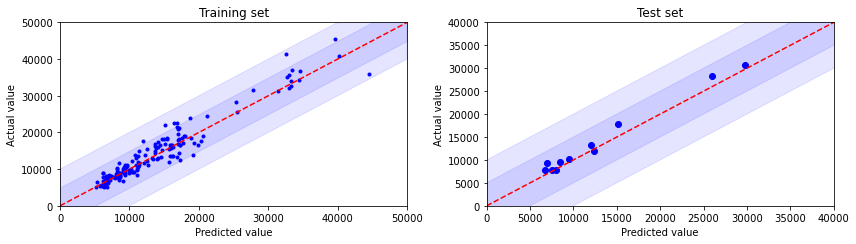

In [28]:
#Best hyperparameters
hidden1 = 5
hidden2 = 2
alpha = 0.5
function = "tanh"

#Training on X_train and test on X_test
lastiter, t1, t2, t3, costr, cosval = Training("regression", function, X_train_regr, y_train_regr, X_test_regr, y_test_regr, alpha, 0.0, 5000, hidden1, hidden2, flag = False)

                    
#Results
Prob_tr, Pred_tr = Prediction("regression", function, X_train_regr, t1, t2, t3)
Prob_te, Pred_te = Prediction("regression", function, X_test_regr, t1, t2, t3)    
Results1 = pd.DataFrame(np.concatenate([Pred_tr,np.array(y_train_regr).reshape(len(y_train_regr),1)],axis=1),columns=["Predicted","Actual"])
Results2 = pd.DataFrame(np.concatenate([Pred_te,np.array(y_test_regr).reshape(len(y_test_regr),1)],axis=1),columns=["Predicted","Actual"])
print("\nRMSE - Training set (linear units): {:.2f} USD".format(np.sqrt(((10**Results1.Predicted - 10**Results1.Actual)**2).sum()/len(Results1))))
print("RMSE - Test set (linear units): {:.2f} USD".format(np.sqrt(((10**Results2.Predicted - 10**Results2.Actual)**2).sum()/len(Results2))))
print("RMLSE - Training set: {:.2f}".format(np.sqrt((( np.log10(10**Results1.Predicted+1) - np.log10(10**Results1.Actual+1))**2).sum()/len(Results1))))
print("RMLSE - Test set: {:.2f}".format(np.sqrt((( np.log10(10**Results2.Predicted+1) - np.log10(10**Results2.Actual+1))**2).sum()/len(Results2))))
print("MAE - Training set (linear units): {:.2f} USD".format( (abs(10**Results1.Predicted - 10**Results1.Actual)).sum()/len(Results1) ))
print("MAE - Test set (linear units): {:.2f} USD".format( (abs(10**Results2.Predicted - 10**Results2.Actual)).sum()/len(Results2) ))
print("MPE - Training set: {:.2f} %".format( 100*(abs(10**Results1.Predicted - 10**Results1.Actual)/(10**Results1.Actual)).sum()/len(Results1) ))
print("MPE - Test set: {:.2f} %".format( 100*(abs(10**Results2.Predicted - 10**Results2.Actual)/(10**Results2.Actual)).sum()/len(Results2) ))



#Plot
plt.figure(figsize=(12,3.5))
plt.subplot(1,2,1)
plt.plot(10**Results1.Predicted,10**Results1.Actual,'.b')
plt.plot([0,50000],[0,50000],'--r')
plt.xlim([0,50000])
plt.ylim([0,50000])
plt.fill_between([0,50000], [5000,55000], [-5000,45000], color="blue",alpha=0.1)
plt.fill_between([0,50000], [10000,60000], [-10000,40000], color="blue",alpha=0.1)
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Training set")
plt.subplot(1,2,2)
plt.plot(10**Results2.Predicted,10**Results2.Actual,'ob')
plt.plot([0,50000],[0,50000],'--r')
plt.xlim([0,40000])
plt.ylim([0,40000])
plt.fill_between([0,50000], [5000,55000], [-5000,45000], color="blue",alpha=0.1)
plt.fill_between([0,50000], [10000,60000], [-10000,40000], color="blue",alpha=0.1)
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Test set")
plt.tight_layout()